In [20]:
import pandas as pd
import numpy as np 

from gensim import corpora
from gensim.models import LsiModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.matutils import corpus2dense, corpus2csc

import matplotlib.pyplot as plt

from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.lda_model

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer


## Latent Sematic Analysis (LSA)

In [21]:
data = pd.read_csv("data/preprocessed.csv")
data_spotify = pd.read_csv("data/preprocessed_spotify.csv")
X = data['clean_lyrics'].apply(str.split)

# Create a dictionary and a corpus
dictionary = corpora.Dictionary(X)
dictionary.filter_extremes(no_below= 0.01, no_above= 0.75)

corpus = [dictionary.doc2bow(doc) for doc in X]

# Perform LSA
lsa_model = LsiModel(corpus, id2word=dictionary, num_topics= 8)

# Print the topics
topics = lsa_model.print_topics(num_words=4)
for topic in topics:
    print(topic)



c:\Users\garim\anaconda3\envs\github\lib\site-packages\gensim\models\lsimodel.py:963: DeprecationWarning: `scipy.sparse.sparsetools.csc_matvecs` is deprecated along with the `scipy.sparse.sparsetools` namespace. `scipy.sparse.sparsetools.csc_matvecs` will be removed in SciPy 1.14.0, and the `scipy.sparse.sparsetools` namespace will be removed in SciPy 2.0.0.
  sparsetools.csc_matvecs(
c:\Users\garim\anaconda3\envs\github\lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
c:\Users\garim\anaconda3\envs\github\lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) 

(0, '0.402*"say" + 0.220*"go" + 0.198*"wa" + 0.191*"tell"')
(1, '0.637*"wa" + -0.221*"say" + 0.202*"de" + 0.200*"one"')
(2, '0.319*"thou" + 0.289*"king" + 0.262*"thee" + 0.259*"said"')
(3, '-0.432*"bloom" + -0.271*"bruce" + 0.181*"say" + -0.170*"back"')
(4, '-0.523*"bloom" + 0.241*"bruce" + 0.211*"na" + -0.194*"stephen"')
(5, '0.366*"bruce" + -0.284*"na" + -0.278*"love" + -0.224*"im"')
(6, '-0.689*"feat" + 0.231*"bond" + -0.226*"love" + 0.120*"na"')
(7, '-0.579*"bond" + -0.311*"lawrence" + -0.263*"feat" + -0.246*"natalya"')


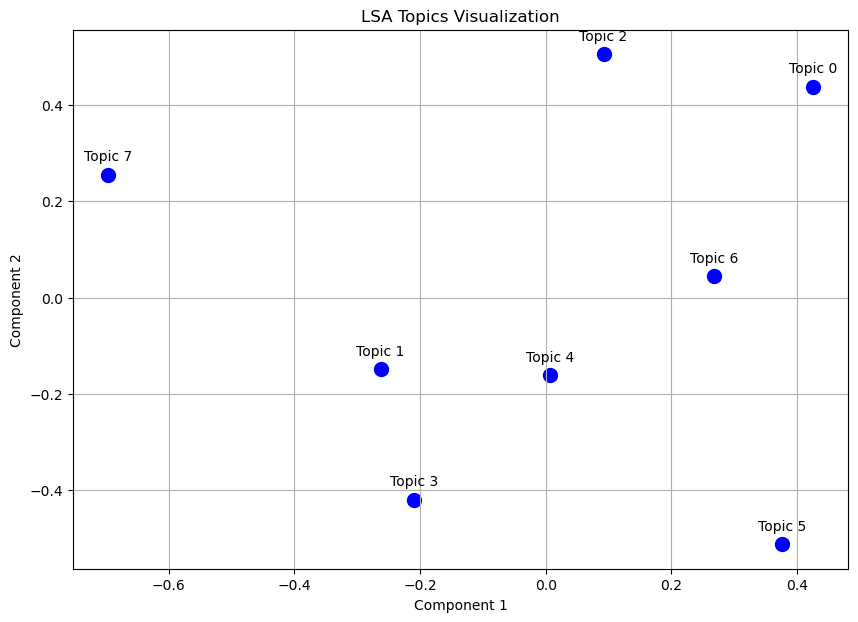

In [22]:
# Get topic vectors
topics = lsa_model.get_topics()  # Shape: (num_topics, num_words)

# Reduce dimensionality
def reduce_dimensionality(vectors, method='tsne'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")
    
    reduced_vectors = reducer.fit_transform(vectors)
    return reduced_vectors

reduced_topics = reduce_dimensionality(topics, method='pca')  # or 'pca'

# Plotting
def plot_topics(reduced_vectors, topic_names):
    plt.figure(figsize=(10, 7))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], marker='o', c='blue', s=100)
    
    for i, name in enumerate(topic_names):
        plt.annotate(name, (reduced_vectors[i, 0], reduced_vectors[i, 1]),
                     textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.title('LSA Topics Visualization')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

# Create topic names
topic_names = [f'Topic {i}' for i in range(lsa_model.num_topics)]

# Plot
plot_topics(reduced_topics, topic_names)

In [23]:
doc_topic = pd.DataFrame(corpus2csc(lsa_model[corpus]).toarray(), columns= data['Song ID']).T
doc_topic

,0,1,2,3,4,5,6,7
Song ID,,,,,,,,
0,3.540194,3.275555,0.017382,-0.404222,-0.000867,-0.114403,0.876936,-0.374853
1,2.673546,0.394208,-0.074931,-1.916486,0.999667,-0.383428,0.386698,-0.087352
2,2.484312,-0.126311,0.142139,-1.484646,2.068359,-3.217057,-0.556464,0.856217
3,2.108798,0.369480,0.023634,-1.262597,0.900296,-2.122902,-1.027276,0.209840
4,3.519742,-0.316088,-0.518454,-2.137379,3.107972,-4.040110,-0.146087,0.600236
...,...,...,...,...,...,...,...,...
5496,9.855320,3.208438,-0.890085,-4.686324,6.598152,-7.354769,3.035999,2.948609
5497,9.150772,2.618697,0.404163,-2.377535,1.882970,-2.295568,0.549750,0.691087
5498,10.110887,1.239333,0.132766,-3.873395,6.724850,-7.856698,2.843458,2.018335


In [24]:
# data['lsa_topic'] = doc_topic.idxmax(axis= 1)
# data['lsa_topic'].value_counts(normalize= True)

In [25]:
# pd.pivot_table(data, index= "Year", columns= "lsa_topic", 
#                values= "Song ID", aggfunc= "count").fillna(0).plot()

## Latent Dirichlet Allocation

In [26]:
# Define helper function to print and return top words
def get_topic_words(lda_model, feature_names, n_words=10, print_words= False):
    topic_words = {}
    for topic_idx, topic in enumerate(lda_model.components_):
        # words = [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]
        # topic_words[f"Topic {topic_idx}"] = words

         # Get words and their weights
        word_weights = {feature_names[i]: topic[i] for i in range(len(feature_names))}
        # Sort words by their weights in descending order
        sorted_words = dict(sorted(word_weights.items(), key=lambda item: item[1], reverse=True))
        topic_words[f"Topic {topic_idx}"] = sorted_words

        # print if needed
        if print_words:
            message = "\nTopic # {}:\n".format(topic_idx)
            message += " ;".join([feature_names[i] for i in topic.argsort()[:-n_words - 1 :-1]])
            print(message)

    return topic_words

# Define a function to compute coherence score using gensim
def compute_coherence_score(lda_model, corpus, dictionary, feature_names):
    topics = []
    for topic_id in range(lda_model.n_components):
        topic_words = [feature_names[i] for i in np.argsort(lda_model.components_[topic_id])[::-1]]
        topics.append(topic_words)
    
    coherence_model = CoherenceModel(topics=topics, texts=corpus, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score

In [27]:
tfidf = TfidfVectorizer(min_df= 0.01, max_df= 0.6, ngram_range= (1,4))
X = tfidf.fit_transform(data_spotify['clean_lyrics'])
feature_names = tfidf.get_feature_names_out()


# Prepare data for coherence calculation
corpus = [text.split() for text in data_spotify['clean_lyrics']]
dictionary = Dictionary(corpus)

In [28]:
coherences = []
perplexities = []

from tqdm import tqdm
for nn in tqdm(range(2,22)):
    lda = LatentDirichletAllocation(n_components= nn, random_state= 0)
    lda.fit_transform(X)
    perplexities.append(lda.perplexity(X))
    coherences.append(compute_coherence_score(lda, corpus, dictionary, feature_names))
    

  5%|▌         | 1/20 [03:39<1:09:34, 219.70s/it]


KeyboardInterrupt: 

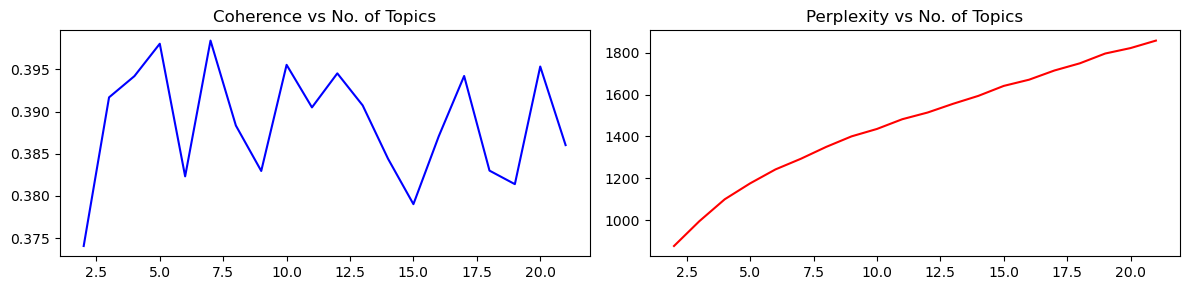

In [ ]:
fig,axs = plt.subplots(figsize= (12,3), ncols= 2)
axs[0].plot(range(2,22), coherences, color= "blue")
axs[0].set_title("Coherence vs No. of Topics", fontsize= 12)

axs[1].plot(range(2,22), perplexities, color= "red")
axs[1].set_title("Perplexity vs No. of Topics", fontsize= 12)

plt.tight_layout();
fig.savefig("images/perplexity_coherence.png")


Topic # 0:
christmas ;love ;sky ;sun ;day ;like ;blue ;light ;come ;moon ;wind ;see ;night ;fly ;dream ;sea ;away ;time ;star ;tree ;river ;eye ;im ;go ;ill ;water ;wa ;snow ;one ;heart ;know ;rain ;way ;morning ;well ;shine ;summer ;let ;home ;song ;life ;hear ;world ;bell ;winter ;take ;year ;little ;long ;bright ;never ;bird ;still ;old ;far ;gone ;sing ;could ;mountain ;rose ;green ;land ;high ;find ;sail ;would ;hand ;cloud ;child ;every ;around ;back ;silver ;say ;make ;look ;keep ;may ;upon ;ha ;fall ;across ;flower ;ocean ;new ;tonight ;shining ;golden ;feel ;wing ;thing ;ive ;wish ;dark ;cold ;warm ;place ;spring ;leaf ;man

Topic # 1:
go ;rock ;dance ;let ;roll ;music ;get ;got ;im ;go go ;like ;night ;going ;come ;baby ;time ;let go ;round ;know ;want ;party ;take ;ready ;dancing ;move ;play ;tonight ;good ;everybody ;well ;radio ;love ;make ;slow ;rhythm ;beat ;way ;feel ;around ;right ;cant ;good time ;turn ;song ;one ;back ;na ;see ;light ;sound ;band ;hear ;stop ;girl ;

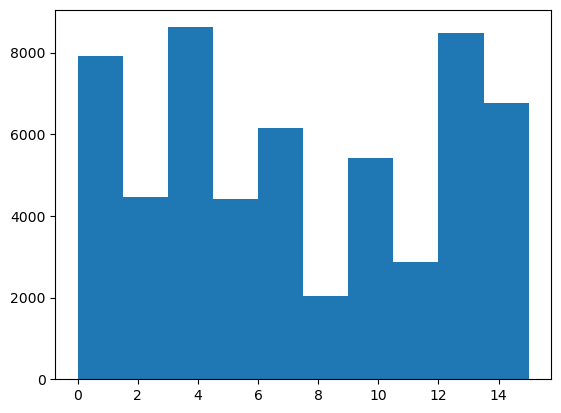

In [32]:
lda = LatentDirichletAllocation(n_components= 16, random_state= 11, max_iter= 20)
doc_topic = lda.fit_transform(X)
plt.hist(np.argmax(doc_topic, axis= 1)); 

topic_words = get_topic_words(lda, feature_names, n_words= 100, print_words= True);

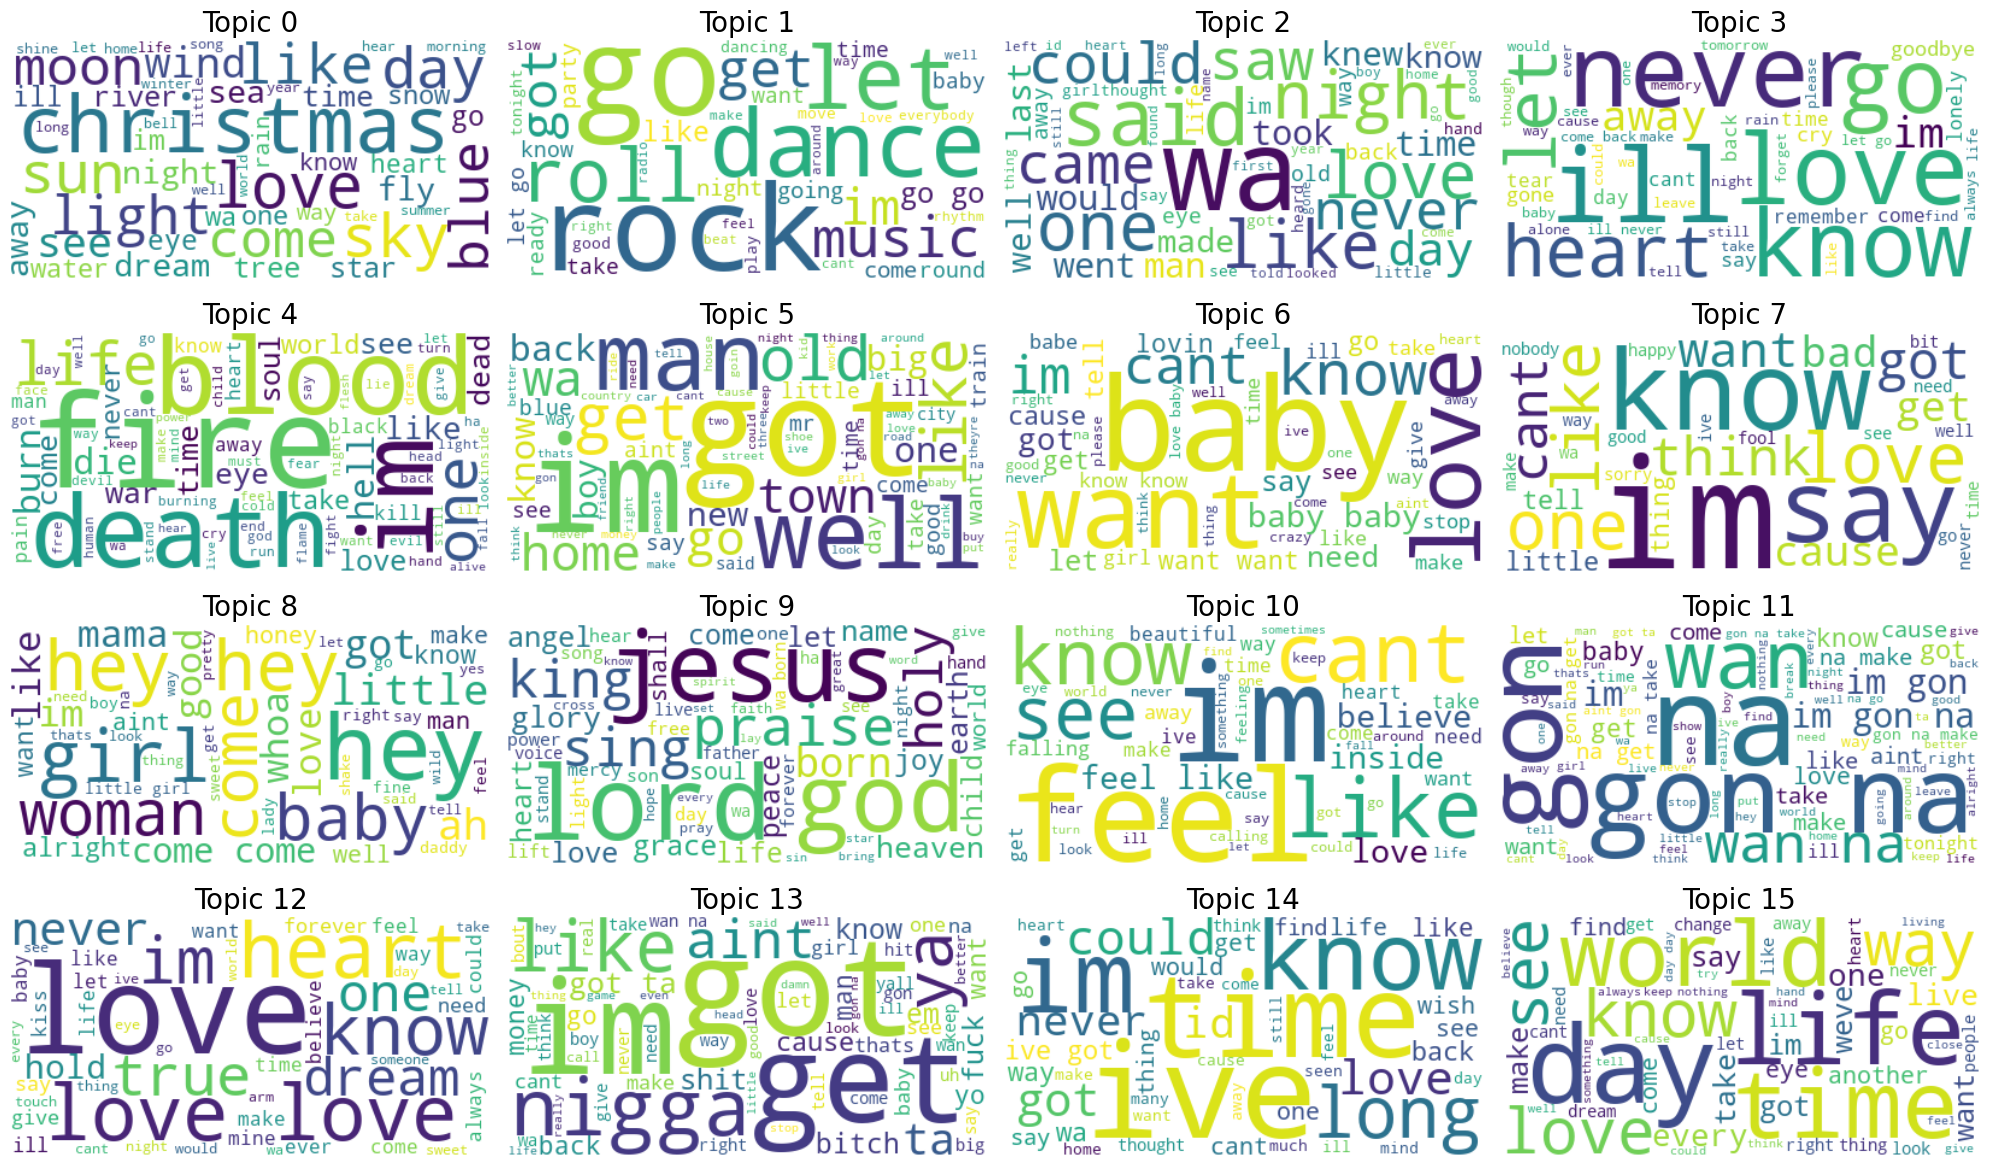

In [33]:
fig,axs = plt.subplots(figsize= (20,12), ncols= 4, nrows= int(np.ceil(lda.n_components/4)) )


def plot_wordcloud(words, title, ax):
    wordcloud = WordCloud(background_color='white', contour_color='steelblue', contour_width=1,
                          colormap='viridis', min_font_size= 10).generate_from_frequencies(words)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize= 20)
    ax.axis('off')

ii = 0; jj = 0
for topic, words in topic_words.items():
    plot_wordcloud(words, topic, axs[ii][jj])
    if jj == 3:
        jj = 0
        ii += 1
    else:
        jj += 1

plt.tight_layout();


In [36]:
import joblib
joblib.dump(lda, 'lda_model.pkl')
joblib.dump(tfidf, 'tfidf.pkl')

['tfidf.pkl']

In [34]:
# Prepare LDAvis visualization
lda_vis = pyLDAvis.lda_model.prepare(lda, X, tfidf)
pyLDAvis.show(lda_vis, local= False)

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [22/Aug/2024 10:06:37] "GET / HTTP/1.1" 200 -



stopping Server...
